# Cross-Lingual Transferability of Voice Analysis Models: a Parkinson's Disease Case Study

## Preliminaries

### Imports

In [1]:
from typing import Tuple, List, Dict, Union, Optional

In [2]:
import os
from ast import literal_eval

In [3]:
import pandas as pd
import librosa

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Constants

In [5]:
EN_DATA_DIR: str = '../resources/data/preprocessed/en/'
EN_METADATA_FILE: str = '../resources/data/preprocessed/en/metadata.csv'
HI_DATA_DIR: str = '../resources/data/preprocessed/hi/'
HI_METADATA_FILE: str = '../resources/data/preprocessed/hi/metadata.csv'

In [6]:
EN_TO_HI_EXPERIMENTS_DIR: str = ''
HI_TO_EN_EXPERIMENTS_DIR: str = ''

In [7]:
OUT_DIR_PATH: str = '../experiments/results'
if not os.path.exists(OUT_DIR_PATH):
    os.mkdir(OUT_DIR_PATH)

In [8]:
LABEL_MAPPING: Dict[str, str] = {
    'healthy': 'Healthy conditions',
    'unhealthy': 'Parkinson\'s disease'
}
FEATURES_MAPPING: Dict[str, str] = {
    'spectral': 'Acoustic and Spectral',
    'vggish': 'VGGish',
    'soundnet': 'SoundNet',
    'wav2vec': 'Wav2Vec 2.0'
}
POOLING_MAPPING: Dict[str, str] = {
    'avg': 'Avg. pooling',
    'max': 'Max pooling',
    'flatten': 'Flattening'
}
ADAPTATION_MAPPING: Dict[bool, str] = {
    False: 'None',
    True: 'CORrelation ALignment (CORAL)'
}
DATA_MAPPING: Dict[str, str] = {
    'src': 'Source data (test split)',
    'tgt': 'Target data'
}
METRICS_MAPPING: Dict[str, str] = {
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'fscore': '$F_1$-score',
    'specificity': 'Specificity',
    'roc_auc': 'ROC AUC',
    'support': 'Support',
    'fpr': 'False positives rate',
    'tpr': 'True postives rate',
    'roc_thresholds': 'Threshold (from ROC curve)',
    'precisions': 'Precision score',
    'recalls': 'Recall score',
    'pr_rc_thresholds': 'Threshold (from precision-recall) curve',
    'confusion_matrix': 'Confusion matrix'
}

In [9]:
DF_COLUMNS: List[str] = ['Input features', 'Pooling approach', 'Domain adaptation', 'Data set', 'Metric', 'Value']

### Utility function(s)

In [10]:
def get_duration(path: str) -> Optional[float]:
    if os.path.exists(path):
        return librosa.get_duration(filename=path)
    else:
        return None

In [11]:
def convert_series(raw_series: pd.Series) -> Tuple[
    str, str, str, str, str, Union[float, int, List[float], List[List[int]]]
]:
    feature: str = FEATURES_MAPPING[raw_series['feature']]
    pooling: str = POOLING_MAPPING[raw_series['pooling']]
    adaptation: str = ADAPTATION_MAPPING[raw_series['adaptation']]
    data: str = DATA_MAPPING[raw_series['data_set']]
    metric: str = METRICS_MAPPING[raw_series['metric']]
    value = literal_eval(raw_series['value'])

    return feature, pooling, adaptation, data, metric, value

In [12]:
def convert_results_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    df: pd.DataFrame = pd.DataFrame(
        [row for _, row in raw_df.iterrows()], columns=DF_COLUMNS
    )

    return df

## Data

Load data

In [13]:
df_en_metadata: pd.DataFrame = pd.read_csv(EN_METADATA_FILE, )
df_en_metadata['Language'] = 'English'
df_en_metadata['Label'] = df_en_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_en_metadata.sample(10)

,file_name,label,original_file_name,start_time,end_time,Language,Label
94,ReadText_HC_ID19_hc_0_0_0_007.wav,healthy,ReadText/HC/ID19_hc_0_0_0.wav,00:02:16.000,00:02:19.000,English,Healthy conditions
326,SpontaneousDialogue_HC_ID11_hc_0_0_0_000.wav,healthy,SpontaneousDialogue/HC/ID11_hc_0_0_0.wav,00:00:28.000,00:00:38.000,English,Healthy conditions
424,SpontaneousDialogue_PD_ID16_pd_2_0_0_006.wav,unhealthy,SpontaneousDialogue/PD/ID16_pd_2_0_0.wav,00:02:10.000,00:02:17.000,English,Parkinson's disease
155,ReadText_HC_ID35_hc_0_0_0_001.wav,healthy,ReadText/HC/ID35_hc_0_0_0.wav,00:00:45.000,00:00:57.000,English,Healthy conditions
293,SpontaneousDialogue_HC_ID00_hc_0_0_0_004.wav,healthy,SpontaneousDialogue/HC/ID00_hc_0_0_0.wav,00:01:32.000,00:01:43.000,English,Healthy conditions
93,ReadText_HC_ID19_hc_0_0_0_006.wav,healthy,ReadText/HC/ID19_hc_0_0_0.wav,00:01:57.000,00:02:05.000,English,Healthy conditions
200,ReadText_PD_ID07_pd_2_0_0_006.wav,unhealthy,ReadText/PD/ID07_pd_2_0_0.wav,00:01:34.000,00:01:40.000,English,Parkinson's disease
421,SpontaneousDialogue_PD_ID16_pd_2_0_0_003.wav,unhealthy,SpontaneousDialogue/PD/ID16_pd_2_0_0.wav,00:01:13.000,00:01:23.000,English,Parkinson's disease
415,SpontaneousDialogue_PD_ID13_pd_3_2_2_006.wav,unhealthy,SpontaneousDialogue/PD/ID13_pd_3_2_2.wav,00:02:13.000,00:02:22.000,English,Parkinson's disease
351,SpontaneousDialogue_HC_ID19_hc_0_0_0_001.wav,healthy,SpontaneousDialogue/HC/ID19_hc_0_0_0.wav,00:00:55.000,00:01:00.000,English,Healthy conditions


In [14]:
df_hi_metadata: pd.DataFrame = pd.read_csv(HI_METADATA_FILE)
df_hi_metadata['Language'] = 'Hindi'
df_hi_metadata['Label'] = df_hi_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_hi_metadata.sample(10)

,file_name,label,original_file_name,start_time,end_time,Language,Label
198,hi_clips_common_voice_hi_34097646_000.wav,healthy,hi/clips/common_voice_hi_34097646.mp3,NaN,NaN,Hindi,Healthy conditions
175,hi_clips_common_voice_hi_34096796_000.wav,healthy,hi/clips/common_voice_hi_34096796.mp3,NaN,NaN,Hindi,Healthy conditions
184,hi_clips_common_voice_hi_34096902_000.wav,healthy,hi/clips/common_voice_hi_34096902.mp3,NaN,NaN,Hindi,Healthy conditions
40,AUD-20210922-WA0022_001.wav,unhealthy,AUD-20210922-WA0022.wav,00:00:28.000,00:00:36.000,Hindi,Parkinson's disease
27,AUD-20210709-WA0004_002.wav,unhealthy,AUD-20210709-WA0004.wav,00:00:28.000,00:00:34.000,Hindi,Parkinson's disease
79,ramanamma_000.wav,unhealthy,ramanamma.wav,00:00:00.000,00:00:14.000,Hindi,Parkinson's disease
70,lakshmi pd ai_003.wav,unhealthy,lakshmi pd ai.wav,00:00:56.000,00:01:09.000,Hindi,Parkinson's disease
186,hi_clips_common_voice_hi_34096946_000.wav,healthy,hi/clips/common_voice_hi_34096946.mp3,NaN,NaN,Hindi,Healthy conditions
159,hi_clips_common_voice_hi_34096442_000.wav,healthy,hi/clips/common_voice_hi_34096442.mp3,NaN,NaN,Hindi,Healthy conditions
19,AUD-20210609-WA0002_000.wav,unhealthy,AUD-20210609-WA0002.wav,00:00:00.000,00:00:10.000,Hindi,Parkinson's disease


In [15]:
df_metadata = pd.concat([df_en_metadata, df_hi_metadata]).reset_index()

df_metadata.sample(10)

,index,file_name,label,original_file_name,start_time,end_time,Language,Label
691,226,hi_clips_common_voice_hi_34686141_000.wav,healthy,hi/clips/common_voice_hi_34686141.mp3,NaN,NaN,Hindi,Healthy conditions
55,55,ReadText_HC_ID11_hc_0_0_0_003.wav,healthy,ReadText/HC/ID11_hc_0_0_0.wav,00:01:14.000,00:01:23.000,English,Healthy conditions
273,273,ReadText_PD_ID33_pd_3_2_2_001.wav,unhealthy,ReadText/PD/ID33_pd_3_2_2.wav,00:00:32.000,00:00:47.000,English,Parkinson's disease
149,149,ReadText_HC_ID31_hc_0_1_1_006.wav,healthy,ReadText/HC/ID31_hc_0_1_1.wav,00:02:11.000,00:02:18.000,English,Healthy conditions
632,167,hi_clips_common_voice_hi_34096735_000.wav,healthy,hi/clips/common_voice_hi_34096735.mp3,NaN,NaN,Hindi,Healthy conditions
193,193,ReadText_PD_ID06_pd_3_1_1_009.wav,unhealthy,ReadText/PD/ID06_pd_3_1_1.wav,00:02:49.000,00:02:58.000,English,Parkinson's disease
490,25,AUD-20210709-WA0004_000.wav,unhealthy,AUD-20210709-WA0004.wav,00:00:00.000,00:00:10.000,Hindi,Parkinson's disease
261,261,ReadText_PD_ID30_pd_2_1_1_003.wav,unhealthy,ReadText/PD/ID30_pd_2_1_1.wav,00:00:50.000,00:00:56.000,English,Parkinson's disease
174,174,ReadText_PD_ID02_pd_2_0_0_007.wav,unhealthy,ReadText/PD/ID02_pd_2_0_0.wav,00:01:48.000,00:02:02.000,English,Parkinson's disease
21,21,ReadText_HC_ID03_hc_0_0_0_002.wav,healthy,ReadText/HC/ID03_hc_0_0_0.wav,00:00:59.000,00:01:10.000,English,Healthy conditions


Distribution of duration (in seconds) of audio files

In [16]:
df_metadata['Duration [s]'] = df_metadata.apply(
    lambda r: get_duration(os.path.join(EN_DATA_DIR if r['Language'] == 'English' else HI_DATA_DIR, r['file_name'])), axis=1
)
df_metadata.sample(10)

,index,file_name,label,original_file_name,start_time,end_time,Language,Label,Duration [s]
523,58,PTT-20210611-WA0000_002.wav,unhealthy,PTT-20210611-WA0000.wav,00:00:27.000,00:00:40.000,Hindi,Parkinson's disease,13.013333
571,106,hi_clips_common_voice_hi_33257381_000.wav,healthy,hi/clips/common_voice_hi_33257381.mp3,NaN,NaN,Hindi,Healthy conditions,4.337313
75,75,ReadText_HC_ID14_hc_0_0_0_006.wav,healthy,ReadText/HC/ID14_hc_0_0_0.wav,00:01:37.000,00:01:45.000,English,Healthy conditions,8.016667
44,44,ReadText_HC_ID09_hc_0_0_0_006.wav,healthy,ReadText/HC/ID09_hc_0_0_0.wav,00:01:53.000,00:02:04.000,English,Healthy conditions,11.019048
586,121,hi_clips_common_voice_hi_33797554_000.wav,healthy,hi/clips/common_voice_hi_33797554.mp3,NaN,NaN,Hindi,Healthy conditions,6.677313
425,425,SpontaneousDialogue_PD_ID17_pd_2_1_0_000.wav,unhealthy,SpontaneousDialogue/PD/ID17_pd_2_1_0.wav,00:00:49.000,00:00:56.000,English,Parkinson's disease,6.995238
667,202,hi_clips_common_voice_hi_34097693_000.wav,healthy,hi/clips/common_voice_hi_34097693.mp3,NaN,NaN,Hindi,Healthy conditions,5.597313
242,242,ReadText_PD_ID24_pd_2_0_0_003.wav,unhealthy,ReadText/PD/ID24_pd_2_0_0.wav,00:01:24.000,00:01:33.000,English,Parkinson's disease,9.007143
126,126,ReadText_HC_ID25_hc_0_0_0_007.wav,healthy,ReadText/HC/ID25_hc_0_0_0.wav,00:02:46.000,00:02:52.000,English,Healthy conditions,5.973810
319,319,SpontaneousDialogue_HC_ID09_hc_0_0_0_005.wav,healthy,SpontaneousDialogue/HC/ID09_hc_0_0_0.wav,00:01:39.000,00:01:49.000,English,Healthy conditions,9.997619


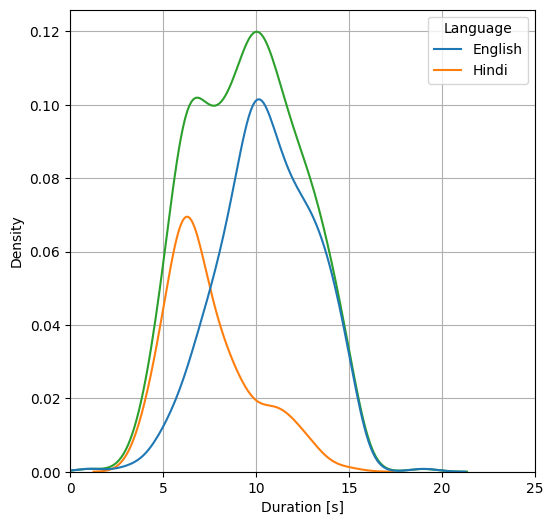

In [17]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata, x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata, x='Duration [s]', hue='Language' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [18]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration.pdf'))

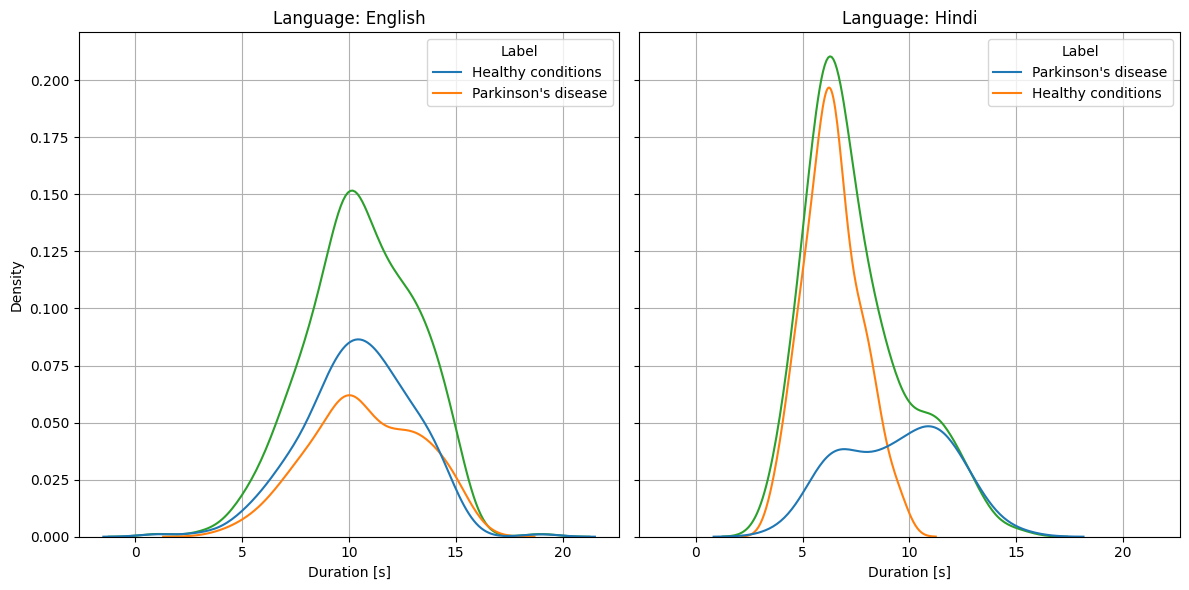

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

for i, (language) in enumerate(['English', 'Hindi']):
    sns.kdeplot(data=df_metadata[df_metadata['Language'] == language], x='Duration [s]', color='tab:green', ax=axes[i])
    sns.kdeplot(
        data=df_metadata[df_metadata['Language'] == language],
        x='Duration [s]',
        hue='Label',
        color=['tab:red', 'tab:blue'],
        ax=axes[i]
    )
    plt.xlabel('Duration [s]')
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Duration [s]')
    axes[i].grid()

plt.tight_layout()
plt.show()

In [20]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_lang.pdf'))

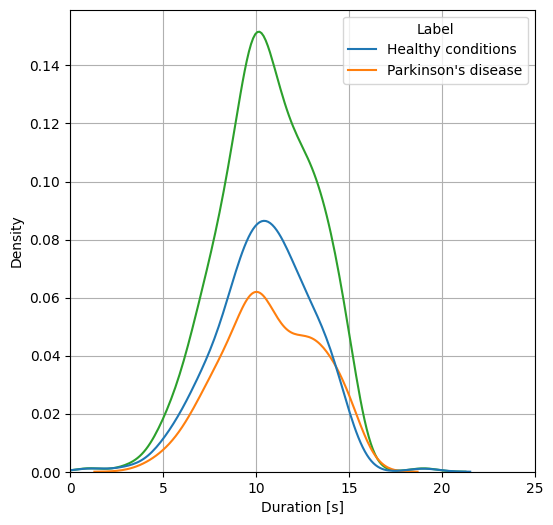

In [23]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:blue'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [24]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_en.pdf'))

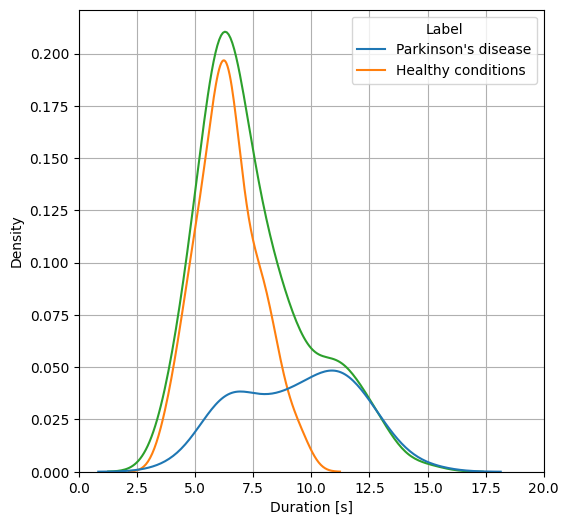

In [28]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Hindi'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Hindi'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 20)
plt.grid()

plt.show()

In [29]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_hi.pdf'))

## Results
Load DataFrames with results

In [ ]:
df_en_to_hi: pd.DataFrame = pd.read_csv(os.path.join(EN_TO_HI_EXPERIMENTS_DIR, 'scores.csv'))
df_en_to_hi = convert_results_df(df_en_to_hi)

In [ ]:
df_hi_to_en = pd.read_csv(os.path.join(HI_TO_EN_EXPERIMENTS_DIR, 'scores.csv'))
df_hi_to_en = convert_results_df(df_hi_to_en)

### Detection in English

### Transferring from English to Hindi

### Detection in Hindi

In [ ]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src'])
]

#### Metrics comparison

In [ ]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 24),
        sharex=True,
        sharey='row'
    )

for i, (_, feature) in enumerate(FEATURES_MAPPING.items()):
    for j, (_, pooling) in enumerate(POOLING_MAPPING):
        sns.barplot(
            data=df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS_MAPPING.keys())
        )
        axes[i].set_title(f'Input features: {feature}, Pooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        # axes[0][i].set_xlim(0.9, tmp_df_coarse[0].max() + 1000)
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_cls_results.pdf'))

#### ROC curve

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_roc_curve.pdf'))

#### Precision-recall curve

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_pr_curve.pdf'))

#### Confusion matrix

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_cm.pdf'))

## Transferring from Hindi to English